# PA5: ConvNets

In this project, we will be visualizing and manipulating AlexNet [1]:
<img src="figures/alexnet.png"/>

For this project, we are using <a href="http://caffe.berkeleyvision.org/">Caffe</a>, an open-source deep learning library that has an efficient implementation of AlexNet.  Other similar libraries include <a href="http://torch.ch/">Torch</a>, <a href="http://deeplearning.net/software/theano/">Theano</a>, and <a href="https://www.tensorflow.org/">TensorFlow</a>.  While the original AlexNet implementation by Alex Krizhevsky is <a href="https://code.google.com/p/cuda-convnet/">cuda-convnet</a>, caffe has a nicer API.

Some parts of this assignment were adapted/inspired from a <a href="http://cs231n.stanford.edu/">Stanford cs231</a> assignment.  The parts that are similar have been modified heavily and ported to caffe.

[1] <a href="https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf">Krizhevsky et al, "ImageNet Classification with Deep Convolutional Neural Networks", NIPS 2012</a>

# 0. Getting Started

## Installing Caffe

To get you started, we have an installation script:
```bash
./install-caffe.sh
```
which will clone Caffe to `~/caffe`, build it, test it, and install the Python interface (`pycaffe`).  After running the script, you will need to restart your iPython Notebook Kernel (menu: Kernel --> Restart).  While this notebook should be self-sufficient, you can find more information on the <a href="http://tutorial.caffe.berkeleyvision.org/">Caffe tutorial page</a> or the <a href="http://caffe.berkeleyvision.org/">Caffe home page</a>.

**Note: It will take about 30-60 minutes to install caffe, depending on your machine.**

## Download / load AlexNet

The below cell downloads AlexNet: both the structure of the network (a `.prototxt` file) and the weights for each layer (a `.caffemodel` file).  The original caffe network is defined in the directory `~/caffe/models/bvlc_alexnet/`.  The below cell will patch the original file (`deploy.prototxt`) to allow you to backprop all the way to the input image, saving it to `patched_alexnet.prototxt` (in the current directory).

Before images can be passed into AlexNet, they first must be "preprocessed" meaning that they are scaled to the correct range (0 to 255), a pre-computed mean is subtracted, the color channel order is flipped (RGB to BGR), and the channels are transposed.  In more detail, Python loads images in "RGB" `(red, green, blue)` channel order, and this must be flipped to "BGR" channel order.  Further, images usually have the shape `(height, width, color channel)`, but in caffe they have shape `(color channel, height, width)`.  When there are multiple images saved in the same matrix, they have shape `(batch index, color channel, height, width)` and are abbreviated as `(N, C, H, W)`.

In [2]:
# Auto reload modules marked with aimport
%load_ext autoreload
%autoreload 1

# Fix the PYTHONPATH before importing caffe
import os, sys
caffe_root = os.path.expanduser('~/caffe/')
sys.path.insert(0, caffe_root + 'python')
import caffe

# Helper function to load AlexNet (take a look in load_alexnet.py if you're curious)
%aimport load_alexnet
net, transformer = load_alexnet.load_alexnet(caffe_root, gpu=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
looking for file:  /home/ubuntu/caffe/models/bvlc_alexnet/bvlc_alexnet.caffemodel
AlexNet found.
Loaded net <caffe._caffe.Net object at 0x7fc82a53b2b8>


#### Ignore warnings

If you get a warning that looks like this, you can safely ignore it:

`caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, `

BVLC is aware of the issue, and there are open GitHub Issues to propose fixes (https://github.com/BVLC/caffe/pull/3960, if you're curious)

## Helper functions

These functions help convert between caffe format (`(color channel, height, width)` in `BGR` order) and the more common Python image format needed for saving/display (`height, width, color channel)` in `RGB` order).

In [3]:
import os, sys,  math, random, subprocess
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, Image, display, HTML
from google.protobuf import text_format
from cStringIO import StringIO
import PIL.Image

# Configure matplotlib to render inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

def preprocess(img):
    """ Process an image by subtracting the mean and converting RGB to BGR """
    return transformer.preprocess('data', img)

def deprocess(img):
    """ Undo image processing (add back the mean and convert BGR to RGB) """
    return transformer.deprocess('data', img)

def load_and_preprocess_image(fname):
    """ Load an image, and process it """
    image = caffe.io.load_image(fname)
    return preprocess(image)

def save_image(img, fname):
    """ Save a floating point image, assumed to be in the range [0, 1] """
    assert img.ndim == 2 or img.ndim == 3  # must be grayscale or RGB
    parent_dir = os.path.dirname(fname)
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
    pil_image = PIL.Image.fromarray(np.clip(img * 255.0, 0, 255).astype(np.uint8))
    pil_image.save(fname)
    
def showarray(img, fmt='jpeg'):
    """ Display an image inline in the notebook, assumed to be in the range [0, 1] """
    assert img.ndim == 2 or img.ndim == 3  # must be grayscale or RGB
    img = np.uint8(np.clip(img * 255.0, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(img).save(f, fmt)
    display(Image(data=f.getvalue()))

## Caffe API: Accessing Data

### Layer, top, bottom

In caffe, each layer in the neural net is called a `Layer` and has a name, such as "conv1".  These are defined in the file `patched_alexnet.prototxt`.

For example, this is the specification for `conv1` (taken from `patched_alexnet.prototxt`):
```
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 96
    kernel_size: 11
    stride: 4
  }
```

The "bottom" is the _input_ to a layer and the "top" is the _output_ of a layer.  Here we can see that we have a layer called `conv1`, it is a convolution, it takes input from a blob named `data`, and produces an output blob named `conv1` (which happens to share the same name as the layer).

### Blob: data and diff

In caffe, intermediate values between layers are saved as "blobs".  The blobs are like a centralized key-value store where variables can be saved by name.  For example, when `conv1` runs, it produces an output ("top") that gets saved into the `conv1` blob.

Each `Blob` stores both `data` and a `diff`.  The `data` is the activations (computed in the forwards pass), and the `diff` is the gradient (computed in the backwards pass).  By convention, when "gradient" or "diff" is used by itself, it is always the gradient of the loss with respect to that blob.  Note that the forwards pass may use the `diff` as a temporary place to save values, so `diff` only contains valid values after performing a backwards pass.

For example, to access the data for the `conv1` layer, which saves its output to a blob named `conv1`, you would write `net.blobs['conv1'].data`, and to access its diff, you would write `net.blobs['conv1'].diff`. By convention, the output of each layer (called its "top") is saved in a blob with the same name as that layer, but this doesn't always have to be the case.

**Reading from a blob**: 
`Blob` objects have a numpy-like interface, so you can access data as `net.blobs['conv1'].data[0, ...]` (to get the activations of the first image in the batch), and you can measure shape with `net.blobs['conv1'].shape`.
Note that when grabbing data from a blob, make a copy of it (using `np.copy`).  Otherwise, the next forwards/backwards pass may destroy your saved data because it was a reference and not a copy.

**Writing to a blob**:
Assign data using `net.blobs['conv1'].data[0, ...] = X`.  The same applies for `diff`.

### In-place layers

The next layer after `conv1` is `relu1`:
```
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
```
Notice that the top and bottom are the same.  This means that the blob `conv1` is _overwritten_ with the result of the ReLU operation.  This is important: this means that if you access `conv1`, it will be _after_ applying ReLU.  There is no blob named `relu1`; `relu1` is the name of the layer, not the top blob.

### Params

Each `Layer` contains a number of parameters, saved as blobs in the dictionary `net.params`.  By convention, the weights are index 0 and the biases are index 1.  For example, the weights for `conv1` are `net.params['conv1'][0].data`, and the gradient of those weights is `net.params['conv1'][0].diff`.

### Forward and backward

You can compute forwards and backwards passes using these functions:

* `net.forward()`: complete forwards pass from `data` all the way to the last layer `prob`.

* `net.forward(start=A, end=B)`: only compute from A to B.  Note that ReLU is a separate layer, and thus if you want to include ReLU in the pass, you need to specify the appropriate ReLU layer and not the layer just before it.

* `net.backward()`: complete backwards pass from the last layer (`prob`) back to the input layer (`data`).  Note that by default, the backwards pass stops at `conv1`, but we have patched the network (specified `force_backward: true`) to make it go back to `data`.

* `net.backward(start=A, end=B)`: backwards pass starting from A, and working back towards B.

### Viewing layer and parameter shapes AlexNet

Let's visualize the shape of each layer and parameter.

# 1. AlexNet: Visualizing its structure

First we will visualize the structure of AlexNet by inspecting its filters, looking at feature map sizes, and visualizing the activations inside.

In [4]:
# for each layer, show the output shape
print "Layer output shapes:\n" + ('-' * 30)
for layer_name, blob in net.blobs.iteritems():
    print "%s\t %s" % (layer_name, blob.data.shape)

print "\nLayer parameter shapes:\n" + ('-' * 30)
for layer_name, param in net.params.iteritems():
    print "%s\t weights: %s  \tbias: %s" % (layer_name, param[0].data.shape, param[1].data.shape)
    
print "\nLayer parameter counts:\n" + ('-' * 30)
total = 0
for layer_name, param in net.params.iteritems():
    c = np.prod(param[0].data.shape) + np.prod(param[1].data.shape)
    print "%s\t %s" % (layer_name, c, )
    total += c
print "\nTotal parameters: %s" % total

Layer output shapes:
------------------------------
data	 (1, 3, 227, 227)
conv1	 (1, 96, 55, 55)
norm1	 (1, 96, 55, 55)
pool1	 (1, 96, 27, 27)
conv2	 (1, 256, 27, 27)
norm2	 (1, 256, 27, 27)
pool2	 (1, 256, 13, 13)
conv3	 (1, 384, 13, 13)
conv4	 (1, 384, 13, 13)
conv5	 (1, 256, 13, 13)
pool5	 (1, 256, 6, 6)
fc6	 (1, 4096)
fc7	 (1, 4096)
fc8	 (1, 1000)
prob	 (1, 1000)

Layer parameter shapes:
------------------------------
conv1	 weights: (96, 3, 11, 11)  	bias: (96,)
conv2	 weights: (256, 48, 5, 5)  	bias: (256,)
conv3	 weights: (384, 256, 3, 3)  	bias: (384,)
conv4	 weights: (384, 192, 3, 3)  	bias: (384,)
conv5	 weights: (256, 192, 3, 3)  	bias: (256,)
fc6	 weights: (4096, 9216)  	bias: (4096,)
fc7	 weights: (4096, 4096)  	bias: (4096,)
fc8	 weights: (1000, 4096)  	bias: (1000,)

Layer parameter counts:
------------------------------
conv1	 34944
conv2	 307456
conv3	 885120
conv4	 663936
conv5	 442624
fc6	 37752832
fc7	 16781312
fc8	 4097000

Total parameters: 60965224


#### Explanation of layer sizes

_(Run the above cell)_

Remember that activations have _structure_, so for the input data layer, we have 3 color channels, and images are 227 pixels across and 227 pixels tall.  For the first  layer (conv1), the output has shape 55x55, because that convolutional filter has a stride > 1; this causes subsampling.

Notice that for the activations, the first dimension in every layer is 1.  This is because we are only running one image at a time; the batchsize is 1.

The layers fc6, fc7, fc8 are fully connected layers.  Thus they don't have 3D structures and are vectors (with 4096, 4096, and 1000 dimensions respectively).

The weights for convolutions are 4D (as discussed in class) and the weights for fully connected layers are 2D.

### Visualizing conv1 filters

Filters in `conv1` are unique in that they take RGB images as input.  This means that we can visualize them as RGB images.  For all other layers, we cannot view them as nice little colored squares because they are much higher dimensional.

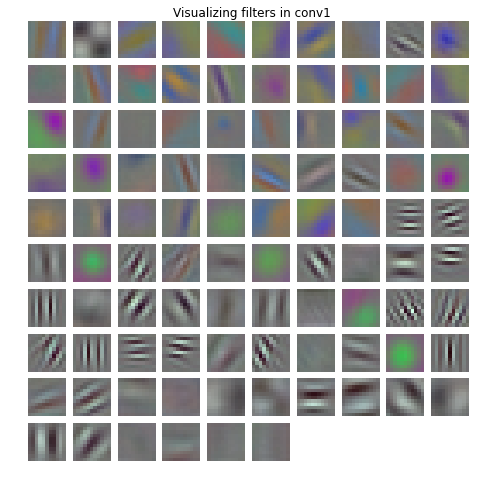

In [5]:
def vis_square(data, title=None):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 2), (0, 2))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    # plot it
    plt.figure(figsize=(8, 8))
    plt.imshow(data)
    plt.axis('off')
    if title: plt.title(title)

filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1), title="Visualizing filters in conv1")

### Visualizing AlexNet activations.

Let's take an example image (of a Pug) and pass it through AlexNet.

Visualize the activations inside all of these layers, using the code below.  Lighter values have higher magnitude, and darker values have smaller magnitude.

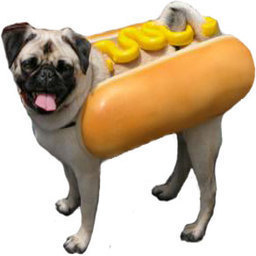

In [6]:
example_fname = 'dataset/test-dog/HOND1.jpg'
display(Image(filename=example_fname))

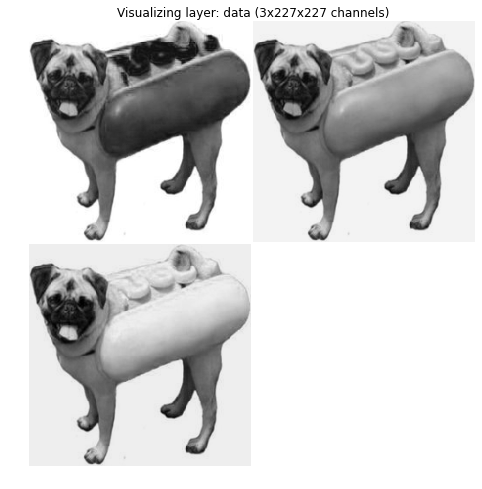

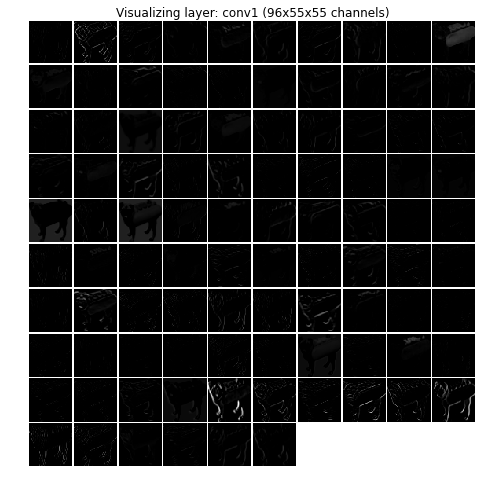

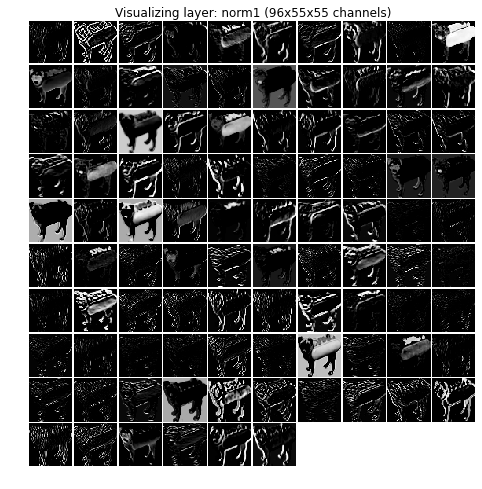

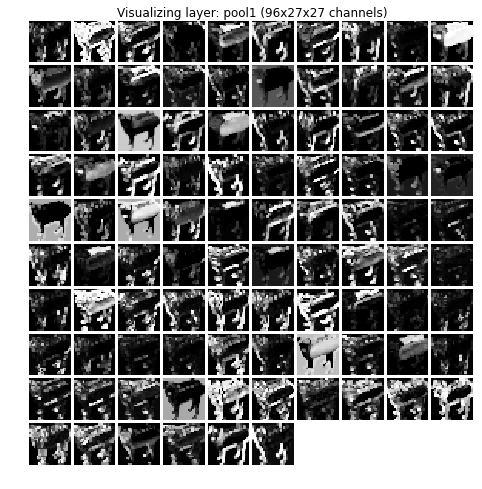

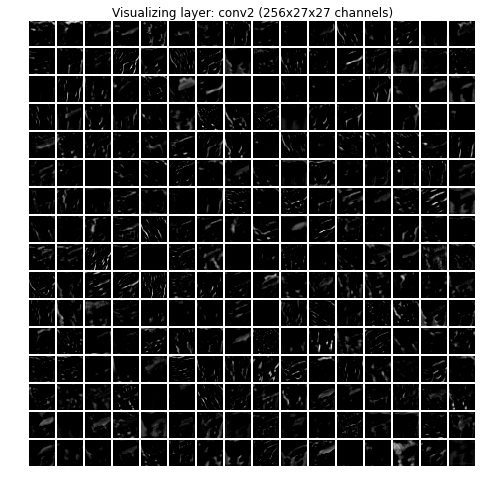

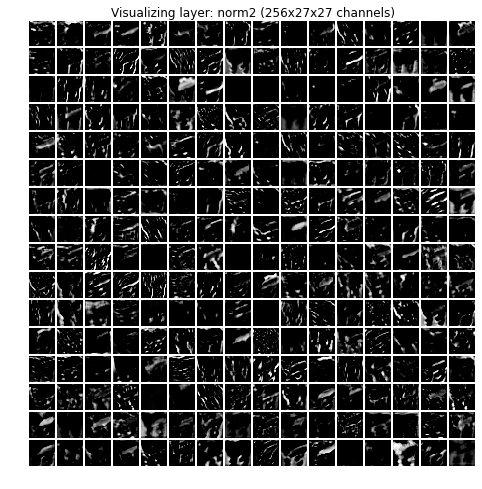

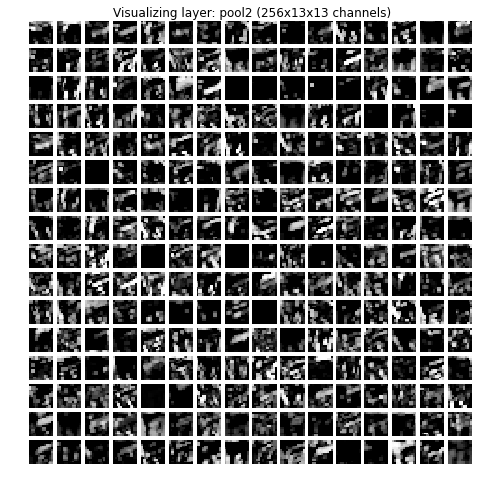

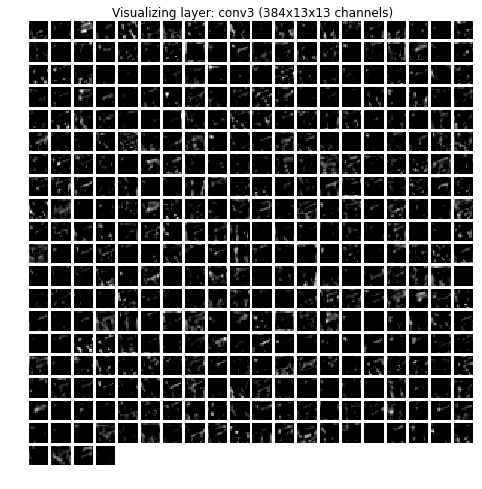

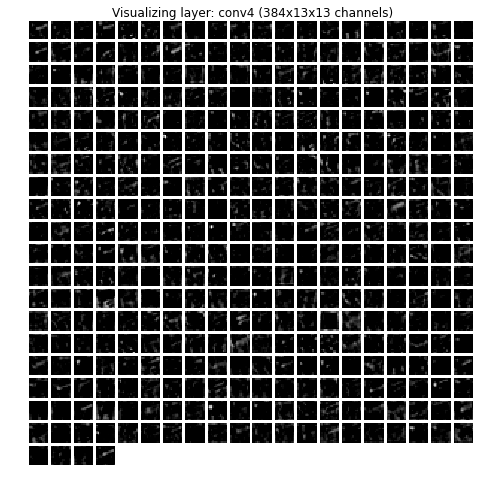

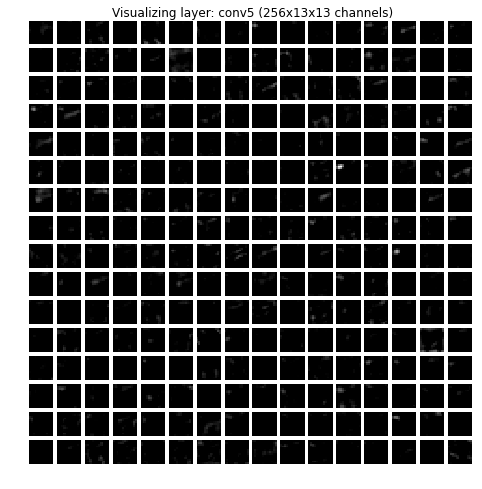

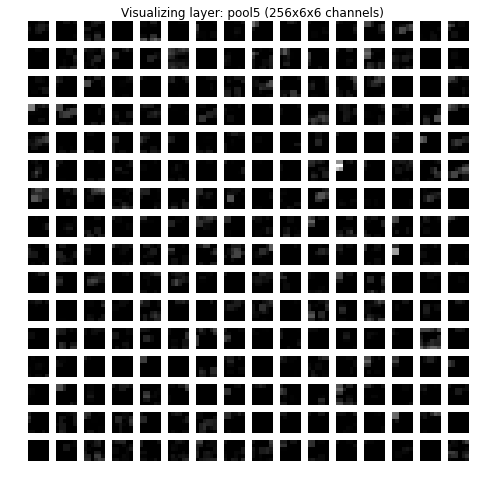

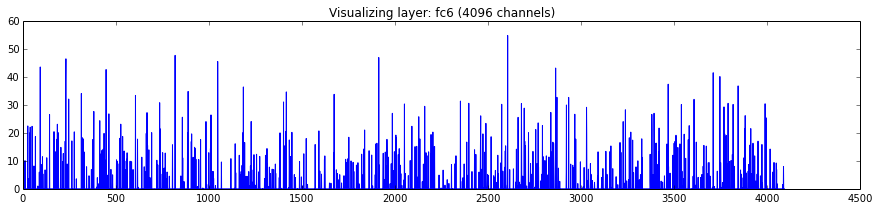

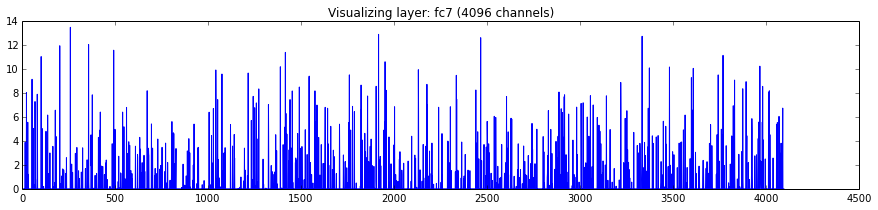

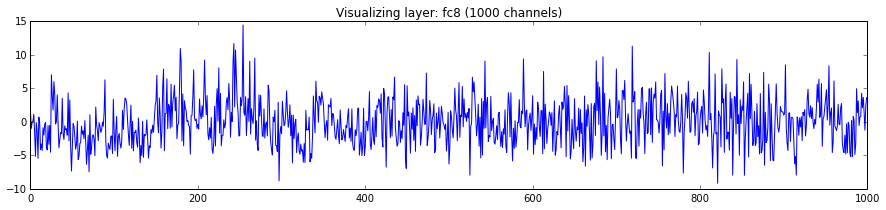

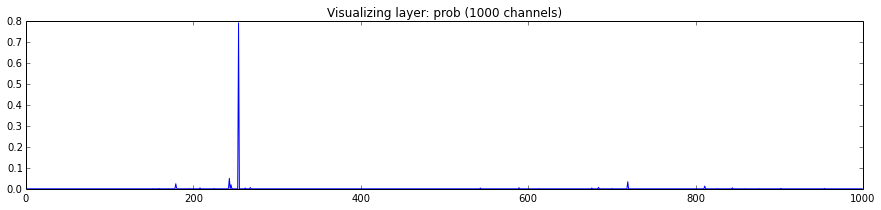

In [7]:
net.blobs['data'].reshape(1, 3, 227, 227)
net.blobs['data'].data[0, ...] = load_and_preprocess_image(example_fname)
net.forward()

for layer_name, param in (net.blobs.iteritems()):
    shape_str = 'x'.join(str(s) for s in net.blobs[layer_name].data.shape[1:])
    if layer_name != 'prob' and not layer_name.startswith('fc'):
        feat = net.blobs[layer_name].data[0, ...]
        vis_square(feat, title="Visualizing layer: %s (%s channels)" % (layer_name, shape_str))
    else:
        feat = net.blobs[layer_name].data[0]
        plt.figure(figsize=(15, 3))
        plt.plot(feat.flat)
        plt.title("Visualizing layer: %s (%s channels)" % (layer_name, shape_str))

### Question

Consider the visualizations produced by the above cell.  Why does fc8 have negative values, but fc6 and fc7 are only positive?

HINT: look at the structure of the network in the file `patched_alexnet.prototxt` (current directory).

**TODO 1**: Put your answer in `student.py` (as a comment)

## Looking up the class names

The output probability vectors from our network will be numerical scores for each of 1000 ImageNet categories. We'll download the English names corresponding to each category so we can get a sense of how well AlexNet is doing, and then plot the scores for the top 10 classes. 

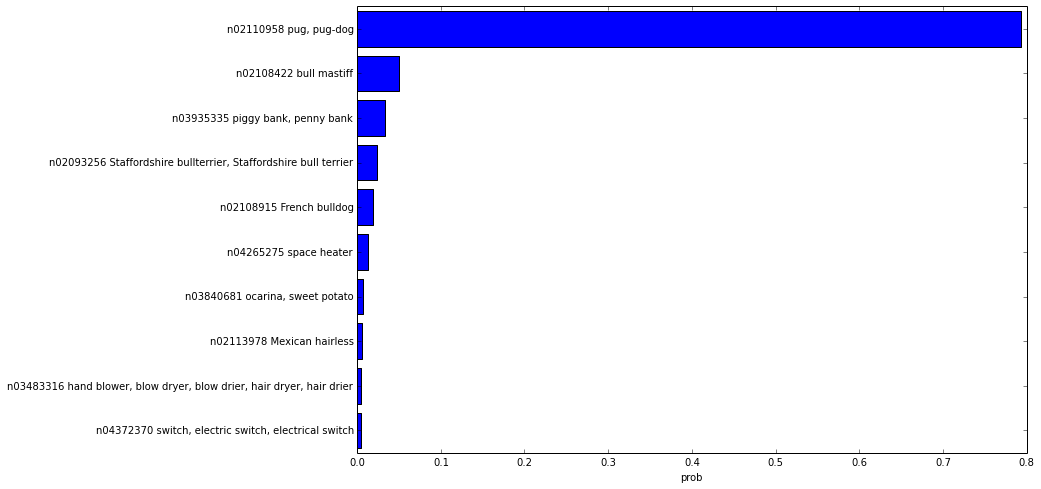

In [8]:
output_prob = net.blobs['prob'].data[0]
ilsvrc_labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(ilsvrc_labels_file):
    print 'downloading synset words...'
    subprocess.call([caffe_root + 'data/ilsvrc12/get_ilsvrc_aux.sh'])
ilsvrc_labels = np.loadtxt(ilsvrc_labels_file, str, delimiter='\t')

top_k = 10
top_indices = np.argsort(output_prob)[-top_k:]
plt.figure(figsize=(12, 8))
plt.barh(np.arange(top_k) + 0.5, output_prob[top_indices], align='center')
plt.xlabel('prob')
plt.yticks(np.arange(top_k) + 0.5, ilsvrc_labels[top_indices])
plt.show()

#### What to expect

We can see that this example was correctly classified, and with high confidence, despite the dog wearing a misleading costume!

# 2. Dog vs Food: Classification

Let's classify dog vs food.  We have prepared a test set of dogs dressed up like hotdogs, and hotdogs cut to look like animals.

The below cell loads the dataset and visualizes all the images in the dataset

In [9]:
import glob, uuid

def show_images(fnames, correct=None, size=128):
    # print all the images inline, optionally color-coding which are correct
    # (the uuid is to avoid caching)
    inline_html = ''.join([
        "<img src='%s?%s' style='width: %spx; margin: 2px; display: inline; border: %s' />" % (
            fname, uuid.uuid4(), size,
            ("4px solid green" if correct[i] else "8px solid red")
            if correct else "1px solid black"
        )
        for i, fname in enumerate(fnames)
    ])
    display(HTML(inline_html))

# Class names
classes = ['dog', 'food']

# Search the local filesystem for files
test_fnames = [sorted(glob.glob('dataset/test-%s/*.jpg' % cname)) for cname in classes]
for cidx, cname in enumerate(classes):
    print "Found %s %s test images" % (len(test_fnames[cidx]), cname)
    show_images(test_fnames[cidx], size=64)
    
# Make sure we found the images
assert len(test_fnames[0]) == 33
assert len(test_fnames[1]) == 25

Found 33 dog test images


Found 25 food test images


### Repurposing the ILSVRC2012 Classifier

AlexNet was trained to recognize one of 1000 classes.  We can repurpose it for our "food vs dog" task by remapping the categories.

Below is a helper function to process a batch of images (you need to run the cell once).

In [10]:
# Helper function to process a batch of images
def batch_forward_pass(fnames, blob_name):
    """ Process a batch of images.  Each image is loaded one-by-one, its output is extracted
    
    :param fnames: list of filenames to process
    :param blob_name: which blob to extract from the network each forwards pass
    """
    outputs = []
    for i, fname in enumerate(fnames):
        print '\rProcessing: %s/%s (%r)' % (i+1, len(fnames), fname),
        # load an image and pre-process it
        # (subtract mean, convert to BGR order, scale up to 255)
        data = load_and_preprocess_image(fname)
        # put the data at the beginning of the network
        net.blobs['data'].reshape(1, 3, 227, 227)
        net.blobs['data'].data[0, ...] = data
        # forward pass: compute every layer
        net.forward()
        # extract and store the output
        net_output = np.copy(net.blobs[blob_name].data[0, :])
        outputs.append(net_output)
    print ""
    return np.array(outputs)

To estimate the probability of "food", we take the sum of all food-related ILSVRC2012 classes, and to estimate the probability of "dog", we do the same for dogs.  Dog is class 0, and food is class 1.

Write a method to compute the probability of our two classes, based on the AlexNet output.  Normalize your answer so that it sums to 1.

**TODO 2**: Implement `convert_ilsvrc2012_probs_to_dog_vs_food_probs` in `student.py`.

In [11]:
%aimport student

# batch forward
all_probs = []
for cidx, cname in enumerate(classes):
    batch_fnames = test_fnames[cidx] # current batch of images
    N = len(batch_fnames) # number of items in the batch
    probs_ilsvrc = batch_forward_pass(batch_fnames, blob_name='prob')
    
    probs = student.convert_ilsvrc2012_probs_to_dog_vs_food_probs(probs_ilsvrc)
    
    # Check shape
    assert probs.shape == (N, 2)
    # Check that probs are normalized
    np.testing.assert_almost_equal(np.sum(probs, axis=1), np.ones(N), decimal=5)
    
    all_probs.append(probs)
all_probs = np.array(all_probs)

Processing: 33/33 ('dataset/test-dog/tumblr_o3dbrrtZZU1ugq6pro1_1280.jpg') 
Processing: 25/25 ('dataset/test-food/tz-biz-100701-hotdog-436p.jpg') 


### Measure the accuracy

You should expect to get around 85% and 96% (+/- 1%) for dog and food respectively.

In [12]:
# compute the accuracy of our method
for cidx, cname in enumerate(classes):
    num_images =  len(test_fnames[cidx])
    predicted = np.argmax(all_probs[cidx], axis=1)
    num_correct = np.sum(predicted == cidx)
    accuracy = 100.0 * float(num_correct) / num_images
    print "Accuracy: %s %s/%s (%s%%)" % (cname, num_correct, num_images, accuracy)

Accuracy: dog 28/33 (84.8484848485%)
Accuracy: food 24/25 (96.0%)


# 3. Dog vs Food: Visualization

We can sort the predictions by the "dog" score and "food" score.  The images are sorted according to how much AlexNet thinks the image belongs to that category.

Images are colored green/red depending on whether the prediction was correct.

For this assignment, you should expect that the incorrect predictions are all near the bottom (with the lowest score).  This is a property that is very desirable -- mistakes only happen with lower scores.  Note that in general real-world tasks, this does not always happen for free.  If you want to be able to estimate the confidence of being correct, you need to separately predict that, and it is not easy to predict.

**TODO 3:** Implement `get_prediction_descending_order_indices` in `student.py`.

In [13]:
%aimport student

for cidx, cname in enumerate(classes):
    print ""
    print "Test images for: %s" % cname
    
    # which items are correct?
    predicted = np.argmax(all_probs[cidx], axis=1)
    correct = [p == cidx for p in predicted]
    
    # Sort the classes in reverse order
    order = student.get_prediction_descending_order_indices(all_probs[cidx], cidx)
    assert len(order) == len(test_fnames[cidx]) # check shape
    
    show_images(
        fnames=[test_fnames[cidx][i] for i in order],
        correct=[correct[i] for i in order],
        size=128
    )


Test images for: dog



Test images for: food


# 4. Visualizing saliency

Using our pre-trained AlexNet, we will compute class saliency maps as described in Section 3.1 of [2].  As mentioned in Section 2 of the paper, you should compute the gradient of the image with respect to the unnormalized class score (`fc8`), not with respect to the normalized class probability (`prob`).  You will need to use the `forward` and `backward` methods of the `net` to compute gradients with respect to the image.

We want to compute: $${\partial s_y \over \partial I}$$

where $s_y$ is the score for class $y$ before the final Softmax layer (i.e. layer `fc8`).

We will then visualize the squared magnitude of this (max across color channels), to estimate the saliency of the class across the input image.  See [1] for more details and intuition.

**TODO 4**: Implement `compute_dscore_dimage` in `student.py`.

**HINT**: To compute the desired gradient, imagine that you have created an extra layer that takes $s$ as input (i.e. layer `fc8`), and outputs $s_y$.  For the purposes of this derivation, imagine that the "loss" is $L = s_y$.  If you compute the derivative of this layer, then you will have ${\partial L \over \partial s}$.  Note that this is exactly the definition of the `diff` for the $s$ layer (i.e. the derivative of the loss $L$ with respect to the activations in $s$).  Thus, you can set the `diff` for the $s$ layer (i.e. layer `fc8`) equal to ${\partial L \over \partial s} = {\partial s_y \over \partial s}$.  Then, continue the backprop process starting from layer `fc8` and continue back to the image (`data` layer).

**NOTE**: You don't need to call `net.forward()` in your function; this has already been run for you.  Same for all gradient functions you implement below.

[2] <a href="http://arxiv.org/pdf/1312.6034.pdf">Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.</a>

In [14]:
%aimport student

def visualize_saliency(data):
    net.blobs['data'].reshape(1, 3, 227, 227)
    net.blobs['data'].data[0, ...] = data
    net.forward()
    argmax_idx = np.argmax(net.blobs['prob'].data[0])
    grad = student.compute_dscore_dimage(net, data, argmax_idx)
    vis = grad * grad
    vis /= np.percentile(vis, q=99.9)
    vis = np.max(vis, axis=0)
    return vis

num_images = 6
for cidx, cname in enumerate(classes):
    fnames = []
    for i, fname in enumerate(test_fnames[cidx][:num_images]):
        print '\rProcessing: %s/%s (%r)' % (i+1, num_images, fname),
        
        data = load_and_preprocess_image(fname)
        vis_image = visualize_saliency(data)
        
        # Check the shape and save
        assert vis_image.shape == (227, 227)
        vis_fname = 'vis/%s-%s.png' % (cidx, i)
        save_image(vis_image, vis_fname)
        
        fnames.append(fname)
        fnames.append(vis_fname)
    
    print "\nSaliency maps for %s" % cname
    show_images(fnames, size=200)

Processing: 6/6 ('dataset/test-dog/58153640_59de7a51b9.jpg') 
Saliency maps for dog


Processing: 6/6 ('dataset/test-food/64cff4c59c8d113b1fda40077e7d8f1d.jpg') 
Saliency maps for food


# 5. Fooling AlexNet

For many machine learning models, it is possible to "fool" them by tweaking the image slightly so that the image is predicted to become any category [1].  Given any image, and any target class, you can perform gradient ascent to maximize the score of that target class (equivalently, gradient descent on the negative score of that class), stopping when the network confidently predicts it as the target class.

Again, maximize the score with respect to the unnormalized class score (`fc8`) and not the normalized class probability (`prob`).  You can reuse the `compute_dscore_dimage` you defined in the previous cell.

In addition to maximizing the score (minimizing the negative score), also add a regularizer that computes the L2 norm between the original image, and the fooling image.  The final gradient will be the sum of the gradient from the regularizer and the gradient from maximizing the class score.

We can write this as a loss $L$:
$$
L = -s_y(I) + R(I)
$$

where $$
R(I) = 0.5 \lambda \|I - I_\text{orig}\|_2^2
$$
$y$ is the target class, and $\lambda$ is the regularization.

#### Momentum
When optimizing functions with ConvNets, typically youuse use gradient descent with momentum, which has the update rule:
$$V_t = \mu V_{t-1} - \alpha G$$
$$I_t = I_{t-1} + V_{t}$$

where $V$ is the velocity, $\alpha$ is the learning rate, $\mu$ is the momentum parameter, $t$ is the iteration number, and $G = \frac{\partial L}{\partial I_{t-1}}$ is the gradient.

To improve stability, we will use a slightly different update, which normalizes the gradient $G$ to have unit norm:
$$V_t = \mu V_{t-1} - \alpha \frac{G}{\|G\|}$$
$$I_t = I_{t-1} + V_{t}$$

**TODO 5a**: Implement the above update rule, `normalized_sgd_with_momentum_update`, in `student.py`.

** TODO 5b**: Implement `fooling_image_gradient` which returns the gradient of the loss with respect to the image $({\partial L \over \partial I})$.  You can reuse the function you implemented above (`compute_dscore_dimage`) to compute ${\partial s_y \over \partial I}$.

[1] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [15]:
%aimport student

def make_fooling_image(fname, target_class, learning_rate, regularization,
                       num_iter, momentum, threshold=0.9):
    """
    Fool AlexNet into thinking that any image has a particular class, by perturbing it just a little bit
    
    :param fname: starting image filename
    :param target_class: the class that this will become after optimization
    :param learning_rate: either a constant, or a function that returns the learning rate at each iteration
    :param regularization: lambda parameter to multiply the regularizer
    :param num_iter: maximum number of iterations
    :param momentum: amount of momentum to use in the SGD 
    :param threshold: the target score for target_class
    """
    data = load_and_preprocess_image(fname)
    net.blobs['data'].reshape(1, 3, 227, 227)
    velocity = np.zeros_like(data)
    
    # This is the original image (used by the regularizer)
    orig_data = np.copy(data)
    for i in xrange(num_iter):
        net.blobs['data'].data[0, ...] = data
        net.forward()
        cur_prob = net.blobs['prob'].data[0, target_class]
        
        # compute the gradient
        grad = student.fooling_image_gradient(
            net, orig_data, data, target_class, regularization)
        
        # update the image with the SGD rule
        data, velocity = student.normalized_sgd_with_momentum_update(
            data, grad, velocity, momentum, learning_rate)
        
        # visualize the current state
        showarray(deprocess(data))
        print fname
        print "Fooling AlexNet into thinking this is a: %r..." % ilsvrc_labels[target_class]
        print '(%s/%s), %s%% confidence' % (i+1, num_iter, cur_prob * 100)
        clear_output(wait=True)
        
        if cur_prob > threshold:
            break
    
    delta = (data - orig_data)
    return data, delta

num_images = 2
all_fnames = []
target_class=113
for cidx, cname in enumerate(classes):
    fnames = []
    for i, fname in enumerate(test_fnames[cidx][:num_images]):
        data, delta = make_fooling_image(
            fname,
            target_class=target_class,
            learning_rate=100,
            regularization=5e-5,
            num_iter=100,
            momentum=0.9)

        fooling_fname = 'fooling/%s-%s.png' % (cidx, i)
        save_image(deprocess(data), fooling_fname)
        
        # Save 5x magnified delta image
        delta = 0.5 + (5.0/255.0) * delta
        delta = delta.transpose(1, 2, 0)  # BGR --> RGB
        delta_fname = 'fooling/%s-%s-delta.png' % (cidx, i)
        save_image(delta, delta_fname)
        
        fnames.append([fname, fooling_fname, delta_fname])
    all_fnames.append(fnames)
    
for cidx, cname in enumerate(classes):
    print ("\nLeft: original, middle: fooling image, right: difference magnified by 5x (gray is 0).\n"
        "AlexNet will classify the middle image in each row as %r with high confidence" % (
        ilsvrc_labels[target_class]))
    for group in all_fnames[cidx]:
        show_images(group, size=200)


Left: original, middle: fooling image, right: difference magnified by 5x (gray is 0).
AlexNet will classify the middle image in each row as 'n01944390 snail' with high confidence



Left: original, middle: fooling image, right: difference magnified by 5x (gray is 0).
AlexNet will classify the middle image in each row as 'n01944390 snail' with high confidence


# 6. Class visualization

We can visualize the knowledge inside AlexNet by starting with random noise and maximizing the probability of a certain class [2, 4].  This is similar to the idea of making a "fooling" image, except that the regularizer is a little different.

Again, we can write this as a loss $L$ depending on the image $I$:
$$
L = -s_y(I) + R(I)
$$

where $$
R(I) = 0.5 \lambda \|I\|_2^2
$$
$y$ is the target class, and $\lambda$ is the regularization.

**TODO 6**: Implement `class_visualization_gradient` (in `student.py`): compute the gradient of the loss $({\partial L \over \partial I})$, which is a combination of the gradient from $-{\partial s_y \over \partial I}$ and the regularization ${\partial R(I) \over \partial I}$.  As before, call `compute_dscore_dimage` to compute ${\partial s_y \over \partial I}$.

[2] <a href="http://arxiv.org/pdf/1312.6034.pdf">Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.</a>

[4] <a href="http://yosinski.com/media/papers/Yosinski__2015__ICML_DL__Understanding_Neural_Networks_Through_Deep_Visualization__.pdf">Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop</a>

In [16]:
%aimport student

def make_class_visualization(target_class, learning_rate, regularization, num_iter,
                             max_jitter, blur_sigma, momentum):
    """
    Visualize an ILSVRC2012 class by maximizing the probability of that class, starting from random.
    
    :param target_class: what ILSVRC2012 class to visualize
    :param learning_rate: either a constant, or a function that returns the learning rate at each iteration
    :param regularization: lambda parameter to multiply the regularizer
    :param num_iter: number of iterations
    :param max_jitter: amount of jitter to add for regularization
    :param blur_sigma: blur each iteration by this amount.
    :param momentum: amount of momentum to use in the SGD update
    """
    data = 100 * np.random.randn(3, 227, 227)
    net.blobs['data'].reshape(1, 3, 227, 227)
    velocity = np.zeros_like(data)
    
    for i in xrange(num_iter):
        # Random jitter to regularize
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        data = np.roll(np.roll(data, ox, -1), oy, -2)
        velocity = np.roll(np.roll(velocity, ox, -1), oy, -2)
        
        # Compute the current class score
        net.blobs['data'].data[0, ...] = data
        net.forward()
        cur_prob = net.blobs['prob'].data[0, target_class]
        
        # Compute the gradient
        grad = student.class_visualization_gradient(
            net, data, target_class, regularization)
        
        # Normalized SGD+Momentum update
        data, velocity = student.normalized_sgd_with_momentum_update(
            data, grad, velocity, momentum, learning_rate)
        
        # Undo jitter
        data = np.roll(np.roll(data, -ox, -1), -oy, -2)
        velocity = np.roll(np.roll(velocity, -ox, -1), -oy, -2)
        
        # blur the image every iteration
        for c in xrange(3):
            data[c, ...] = gaussian_filter(data[c, ...], sigma=blur_sigma)
        
        # Visualize our current result
        showarray(deprocess(data))
        print "Generating visualization of: %r..." % ilsvrc_labels[target_class]
        print '(%s/%s), %s%% confidence' % (i+1, num_iter, cur_prob * 100)
        clear_output(wait=True)
    
    return deprocess(data)

### Generate images!

Use `make_class_visualization` to visualize an example Flamingo or Tarantula.  You can play around with the hyperparameters or generate new classes, but you must at least generate a Flamingo or Tarantula.

The list of classes is in `~/caffe/data/ilsvrc12/synset_words.txt` (this is downloaded in a cell above).

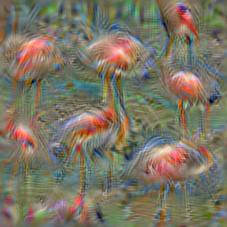

Generating visualization of: 'n02007558 flamingo'...
(250/250), 100.0% confidence


In [17]:
data = make_class_visualization(
    target_class=130, # flamingo
    learning_rate=200,
    regularization=1e-7,
    num_iter=250,
    max_jitter=5,
    blur_sigma=0.4,
    momentum=0.9,
)
save_image(data, 'classvis/class130-flamingo.png')

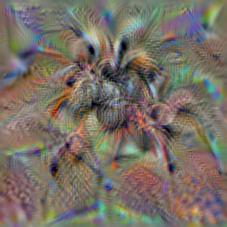

Generating visualization of: 'n01774750 tarantula'...
(250/250), 100.0% confidence


In [18]:
data = make_class_visualization(
    target_class=76, # tarantula
    learning_rate=200,
    regularization=1e-7,
    num_iter=250,
    max_jitter=5,
    blur_sigma=0.4,
    momentum=0.9,
)
save_image(data, 'classvis/class76-tarantula.png')

In [ ]:
# Try other classes here!
# (make sure to call save_image with a new filename)

# 7. Feature Inversion

Instead of generating new examples, we can try and _reconstruct_ examples starting from the hidden representation of a single layer [5].  While [4] and [5] use better regularizers, we are going to use a simple L2 regularizer.

Concretely, given a image $I$, let $\phi_\ell(I)$ be the activations at layer $\ell$ of the convolutional network $\phi$. We wish to find an image $I$ with a similar feature representation as $I$ at layer $\ell$ of the network $\phi$ by solving the optimization problem

$$
L = (0.5/M) \|\phi_\ell(I) - \phi_\ell(I')\|_2^2 + R(I)
$$

where $\|\cdot\|_2^2$ is the squared Euclidean norm, and $M$ is the number of entries in $\phi_\ell(I)$.  $M$ was added to make it easier to set $\lambda$, and $R(I)$ is a regularizer.  We can solve this optimization problem using gradient descent (with momentum), computing gradients with respect to the generated image.  We will use L2 regularization of the form:

$$
R(I) = 0.5 \lambda \|I\|_2^2
$$

To improve the reconstruction quality, we will blur the image every few iterations, which is like adding an implicit regularizer to the optimization.

**TODO 7a**: Implement `feature_inversion_gradient`, which computes the gradient of the above loss function with respect to the image, ${\partial L \over \partial I}$.

**HINT:** Imagine that you have added an extra Euclidean loss layer at some layer in the network.  Backprop through that one layer manually (in code that you write), insert the resulting gradient into the network at the right place, and backprop to get the gradient with respect to the image.  Finally, add the gradient from the regularizer $R$.  You should only have to call `net.backward` exactly once.

[5] <a href="http://arxiv.org/pdf/1412.0035.pdf">Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015</a>

[4] <a href="http://yosinski.com/media/papers/Yosinski__2015__ICML_DL__Understanding_Neural_Networks_Through_Deep_Visualization__.pdf">Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop</a>

In [19]:
%aimport student

def make_feature_inversion(fname, blob_name, variable_learning_rate, regularization,
                           num_iter, blur_every, momentum):
    """
    Solve for a feature inversion for a given filename, by reconstructing from a certain layer (blob_name).
    
    :param variable_learning_rate: a function that returns the learning rate at each iteration
    :param regularization: lambda parameter to multiply the regularizer
    :param num_iter: number of iterations
    :param blur_every: how many iterations to wait between blurring the image
    :param momentum: amount of momentum to use in the SGD update
    """
    orig_data = load_and_preprocess_image(fname)
    net.blobs['data'].data[0, ...] = orig_data
    net.forward(end=blob_name)
    
    # target feature value
    target_feat = np.copy(net.blobs[blob_name].data[0])
    
    # start out with random gaussian noise
    data = 20 * np.random.randn(3, 227, 227)
    net.blobs['data'].reshape(1, 3, 227, 227)
    
    # momentum velocity
    velocity = np.zeros_like(data)
    
    for i in xrange(num_iter):
        net.blobs['data'].data[0, ...] = data
        net.forward(end=blob_name)
        
        # learning rate: allow it to vary
        learning_rate = variable_learning_rate(i)
        
        # current feature value
        cur_feat = net.blobs[blob_name].data[0, ...]
        
        # loss function
        loss_target = 0.5 * np.sum(np.square(cur_feat - target_feat)) / target_feat.size
        loss_regulariztion = 0.5 * regularization * np.sum(np.square(data))
        loss = loss_target + loss_regulariztion
        
        # loss gradient
        grad = student.feature_inversion_gradient(
            net, data, blob_name, target_feat, regularization)
        
        # Normalized SGD+Momentum update
        data, velocity = student.normalized_sgd_with_momentum_update(
            data, grad, velocity, momentum, learning_rate)
        
        # Periodically blur the image
        if i > 0 and i < num_iter - 1 and (i % blur_every) == 0:
            # Blur each color channel separately
            for c in xrange(3):
                data[c, ...] = gaussian_filter(data[c, ...], sigma=0.5)

        showarray(deprocess(data))
        print "(%s/%s) Inverting features for %r" % (i+1, num_iter, fname)
        print "Blob name: %r, learning_rate: %.3f, loss: %.3f (%.3f target + %.3f reg)" % (
            blob_name, learning_rate, loss, loss_target, loss_regulariztion)
        clear_output(wait=True)
    
    return deprocess(data)

#### Original image

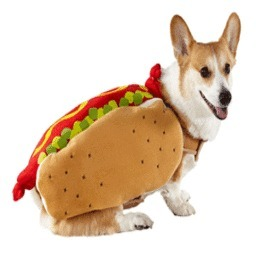

In [20]:
invert_fname = test_fnames[0][10]
display(Image(filename=invert_fname))

#### Reconstructed images

HINT: If you read the paper by Mahendran and Vedaldi, you'll see that reconstructions from deep features tend not to look much like the original image, so you shouldn't expect the results to look like the reconstruction above. You should be able to get an image that shows some discernable structure within 100-1000 iterations.

`conv1` should look pretty close to the original image.  `conv1` should be pretty fast to compute (several iterations per second), but the later layers will be slower (1-5 seconds per iteration).

When debugging, we recommend making sure that conv1 works before trying the other layers.

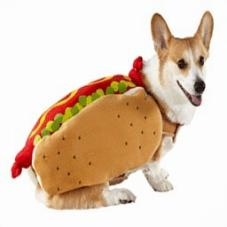

(200/200) Inverting features for 'dataset/test-dog/Halloween-dog-hot-dog.jpg'
Blob name: 'conv1', learning_rate: 136.695, loss: 11.140 (1.009 target + 10.132 reg)


In [21]:
data = make_feature_inversion(invert_fname,
           blob_name='conv1',
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-8,
           num_iter=200,
           blur_every=5,
           momentum=0.9)
save_image(data, 'inversion/conv1.png')

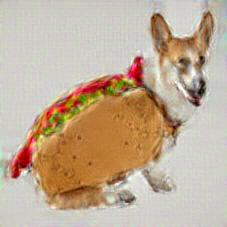

(200/200) Inverting features for 'dataset/test-dog/Halloween-dog-hot-dog.jpg'
Blob name: 'conv2', learning_rate: 136.695, loss: 46.079 (41.473 target + 4.606 reg)


In [22]:
data = make_feature_inversion(invert_fname,
           blob_name='conv2',
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-8,
           num_iter=200,
           blur_every=5,
           momentum=0.9)
save_image(data, 'inversion/conv2.png')

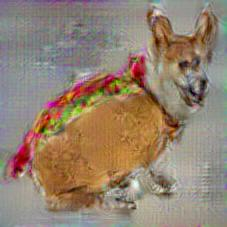

(200/200) Inverting features for 'dataset/test-dog/Halloween-dog-hot-dog.jpg'
Blob name: 'conv3', learning_rate: 136.695, loss: 97.740 (86.633 target + 11.108 reg)


In [23]:
data = make_feature_inversion(invert_fname,
           blob_name='conv3',
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-7,
           num_iter=200,
           blur_every=5,
           momentum=0.9)
save_image(data, 'inversion/conv3.png')

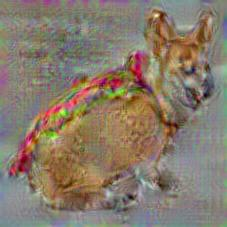

(200/200) Inverting features for 'dataset/test-dog/Halloween-dog-hot-dog.jpg'
Blob name: 'conv4', learning_rate: 136.695, loss: 29.246 (26.137 target + 3.109 reg)


In [24]:
data = make_feature_inversion(invert_fname,
           blob_name='conv4',
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=5e-8,
           num_iter=200,
           blur_every=5,
           momentum=0.9)
save_image(data, 'inversion/conv4.png')

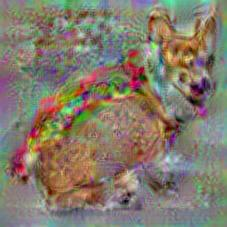

(200/200) Inverting features for 'dataset/test-dog/Halloween-dog-hot-dog.jpg'
Blob name: 'conv5', learning_rate: 136.695, loss: 12.447 (11.636 target + 0.811 reg)


In [25]:
data = make_feature_inversion(invert_fname,
           blob_name='conv5',
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-8,
           num_iter=200,
           blur_every=5,
           momentum=0.9)
save_image(data, 'inversion/conv5.png')

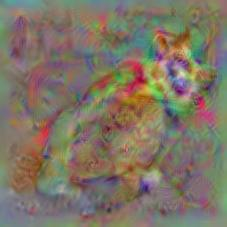

(200/200) Inverting features for 'dataset/test-dog/Halloween-dog-hot-dog.jpg'
Blob name: 'fc6', learning_rate: 136.695, loss: 7.228 (6.848 target + 0.380 reg)


In [26]:
data = make_feature_inversion(invert_fname,
           blob_name='fc6',
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-8,
           num_iter=200,
           blur_every=2,
           momentum=0.9)
save_image(data, 'inversion/fc6.png')

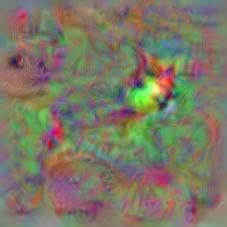

(200/200) Inverting features for 'dataset/test-dog/Halloween-dog-hot-dog.jpg'
Blob name: 'fc8', learning_rate: 136.695, loss: 0.082 (0.078 target + 0.004 reg)


In [27]:
data = make_feature_inversion(invert_fname,
           blob_name='fc8',
           variable_learning_rate=lambda i: 1000.0 * np.exp(-i/100.0),
           regularization=1e-10,
           num_iter=200,
           blur_every=2,
           momentum=0.9)
save_image(data, 'inversion/fc8.png')

### Question

(a) What happens to the quality of the reconstruction as you reconstrut from higher layers?  Why does this happen?  What does this suggest about the representation at each layer?

(b) Why did we adjust the regularization parameter to a different value for some layers?  How might the objective function be changed so that a different value isn't needed for each layer?

**TODO 7b**: Answer in `student.py` as a comment.